<a href="https://colab.research.google.com/github/imposter0/UCCC2513_Mini_Project/blob/main/SensorDataTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.cloud import storage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gcsfs
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

import tensorflow as tf
from tensorflow import keras
from tensorflow import stack
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

from scipy import stats
from scipy.stats import mode

In [2]:
pip install scikeras

In [1]:
from google.colab import auth
auth.authenticate_user()

## Dataset Creation

### Import CSV File

In [4]:
# get list of filepaths from google cloud bucket
csv_file_paths = []

def get_csv_files(project_id="sensordatalogger-logfiles"):
    storage_client = storage.Client(project=project_id)
    bucket = storage.Bucket(storage_client, 'sensordatalogger-logfiles.appspot.com')
    str_folder_name_on_gcs = 'CSVFile/'
    blobs = bucket.list_blobs(prefix=str_folder_name_on_gcs)
    print("Blob name:")
    for blob in blobs:
        csv_file_paths.append(blob.name)

get_csv_files()
print("List of csv files:")
print(csv_file_paths)

Blob name:
List of csv files:
['CSVFile/Log_1_20230814202506.csv', 'CSVFile/Log_1_20230814202822.csv', 'CSVFile/Log_1_20230814203019.csv', 'CSVFile/Log_1_20230910133848.csv', 'CSVFile/Log_1_20230910134100.csv', 'CSVFile/Log_2_20230815131944.csv', 'CSVFile/Log_2_20230815132233.csv', 'CSVFile/Log_2_20230815132348.csv', 'CSVFile/Log_2_20230910134549.csv', 'CSVFile/Log_2_20230910134701.csv', 'CSVFile/Log_3_20230910135254.csv', 'CSVFile/Log_3_20230910135506.csv', 'CSVFile/Log_3_20230910135659.csv', 'CSVFile/Log_3_20230910135917.csv', 'CSVFile/Log_3_20230910140101.csv', 'CSVFile/Log_3_20230910140320.csv', 'CSVFile/Log_3_20230910140552.csv', 'CSVFile/Log_3_20230910140728.csv', 'CSVFile/Log_3_20230910140921.csv', 'CSVFile/Log_3_20230910141143.csv', 'CSVFile/Log_4_20230910135127.csv', 'CSVFile/Log_4_20230910135350.csv', 'CSVFile/Log_4_20230910135604.csv', 'CSVFile/Log_4_20230910135755.csv', 'CSVFile/Log_4_20230910140005.csv', 'CSVFile/Log_4_20230910140203.csv', 'CSVFile/Log_4_20230910140416.csv

In [5]:
# format file name
for i in range(len(csv_file_paths)):
    csv_file_paths[i] = "gs://sensordatalogger-logfiles.appspot.com/" + csv_file_paths[i]
    print(csv_file_paths[i])

gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_1_20230814202506.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_1_20230814202822.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_1_20230814203019.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_1_20230910133848.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_1_20230910134100.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_2_20230815131944.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_2_20230815132233.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_2_20230815132348.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_2_20230910134549.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_2_20230910134701.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_3_20230910135254.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_3_20230910135506.csv
gs://sensordatalogger-logfiles.appspot.com/CSVFile/Log_3_20230910135659.csv
gs://sensord

### Convert CSV File to Parquet File

In [ ]:
parquet_dir = "gs://sensordatalogger-logfiles.appspot.com/ParquetFile/"

def convert_csv_to_parquet(input_file_path, output_file_path):
    csv_df = pd.read_csv(input_file_path, names=['sensor', 'x', 'y', 'z', 'timestamp', 'label'])
    csv_df.to_parquet(output_file_path)

for i in range(len(csv_file_paths)):
    filename = csv_file_paths[i].split('/')[-1]
    filename = filename.replace('csv', 'parquet')
    parquet_file_name = parquet_dir + filename
    print(parquet_file_name)
    convert_csv_to_parquet(csv_file_paths[i], parquet_file_name)

gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230814202506.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230814202822.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230814203019.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230910133848.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230910134100.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230815131944.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230815132233.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230815132348.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230910134549.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230910134701.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_3_20230910135254.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_3_20230910135506.

### Import Parquet File

In [ ]:
# get list of filepaths from google cloud bucket
parquet_file_paths = []

def get_parquet_files(project_id="sensordatalogger-logfiles"):
    storage_client = storage.Client(project=project_id)
    bucket = storage.Bucket(storage_client, 'sensordatalogger-logfiles.appspot.com')
    str_folder_name_on_gcs = 'ParquetFile/'
    blobs = bucket.list_blobs(prefix=str_folder_name_on_gcs)
    print("Blob name:")
    for blob in blobs:
        parquet_file_paths.append(blob.name)

get_parquet_files()
print("List of parquet files:")
print(parquet_file_paths)

Blob name:
List of parquet files:
['ParquetFile/Log_1_20230814202506.parquet', 'ParquetFile/Log_1_20230814202822.parquet', 'ParquetFile/Log_1_20230814203019.parquet', 'ParquetFile/Log_1_20230910133848.parquet', 'ParquetFile/Log_1_20230910134100.parquet', 'ParquetFile/Log_2_20230815131944.parquet', 'ParquetFile/Log_2_20230815132233.parquet', 'ParquetFile/Log_2_20230815132348.parquet', 'ParquetFile/Log_2_20230910134549.parquet', 'ParquetFile/Log_2_20230910134701.parquet', 'ParquetFile/Log_3_20230910135254.parquet', 'ParquetFile/Log_3_20230910135506.parquet', 'ParquetFile/Log_3_20230910135659.parquet', 'ParquetFile/Log_3_20230910135917.parquet', 'ParquetFile/Log_3_20230910140101.parquet', 'ParquetFile/Log_3_20230910140320.parquet', 'ParquetFile/Log_3_20230910140552.parquet', 'ParquetFile/Log_3_20230910140728.parquet', 'ParquetFile/Log_3_20230910140921.parquet', 'ParquetFile/Log_3_20230910141143.parquet', 'ParquetFile/Log_4_20230910135127.parquet', 'ParquetFile/Log_4_20230910135350.parquet

In [ ]:
# format file name
for i in range(len(parquet_file_paths)):
    parquet_file_paths[i] = "gs://sensordatalogger-logfiles.appspot.com/" + parquet_file_paths[i]
    print(parquet_file_paths[i])

gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230814202506.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230814202822.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230814203019.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230910133848.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_1_20230910134100.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230815131944.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230815132233.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230815132348.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230910134549.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_2_20230910134701.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_3_20230910135254.parquet
gs://sensordatalogger-logfiles.appspot.com/ParquetFile/Log_3_20230910135506.

In [ ]:
# read parquet files
for i in range(len(parquet_file_paths)):
    df = pd.read_parquet(parquet_file_paths[i], engine='auto')
    print(df.isnull().values.any())
    print(df.shape)
    print(df)
    print("\n")

False
(12018, 6)
      sensor     x     y     z  timestamp  label
0       ACCE -0.58  9.71 -0.22  299674305      1
1       ACCE -0.58  9.74 -0.23  299674315      1
2       ACCE -0.59  9.76 -0.23  299674325      1
3       ACCE -0.58  9.76 -0.22  299674335      1
4       ACCE -0.58  9.77 -0.22  299674345      1
...      ...   ...   ...   ...        ...    ...
12013   GYRO -0.00  0.01 -0.00  299734647      1
12014   GYRO  0.00  0.00 -0.00  299734657      1
12015   GYRO  0.00 -0.00 -0.00  299734667      1
12016   GYRO  0.00 -0.00 -0.00  299734677      1
12017   GYRO  0.01  0.00 -0.00  299734687      1

[12018 rows x 6 columns]


False
(12028, 6)
      sensor     x     y     z  timestamp  label
0       ACCE -0.89  9.76  0.11  299870823      1
1       ACCE -0.88  9.77  0.11  299870833      1
2       ACCE -0.89  9.78  0.12  299870843      1
3       ACCE -0.83  9.79  0.15  299870853      1
4       ACCE -0.80  9.78  0.15  299870863      1
...      ...   ...   ...   ...        ...    ...
12023  

### Combine Log Files

In [ ]:
preprocessed_parquet_dir = "gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/"

for i in range(len(parquet_file_paths)):
    preprocessed_df = pd.read_parquet(parquet_file_paths[i], engine='auto')
    parts = parquet_file_paths[i].split('/')
    preprocessed_parquet_file_path = preprocessed_parquet_dir + parts[-1]

    # drop null values
    preprocessed_df.dropna(inplace=True)

    # drop the rows where timestamp is 0
    preprocessed_df = preprocessed_df[preprocessed_df['timestamp'] != 0]

    index = 0

    # split accelerometer and gyroscope data
    for r in range(preprocessed_df.shape[0]):
        if preprocessed_df['sensor'].iloc[r] == 'GYRO':
            index = r
            break;

    signals_acce = preprocessed_df.values[:index, 1:6]
    signals_gyro = preprocessed_df.values[index:, 1:6]

    acce_row = signals_acce.shape[0]
    gyro_row = signals_gyro.shape[0]
    keep_row = min(acce_row, gyro_row)

    signals_acce = signals_acce[:keep_row]
    signals_gyro = signals_gyro[:keep_row]

    acce_raw_df = pd.DataFrame(signals_acce, columns=['x', 'y', 'z', 'ts', 'label'])
    gyro_raw_df = pd.DataFrame(signals_gyro, columns=['x2', 'y2', 'z2', 'ts2', 'label2'])

    # sort in ascending order
    acce_raw_df = acce_raw_df.sort_values(by = ['ts'], ignore_index=True)
    gyro_raw_df = gyro_raw_df.sort_values(by = ['ts2'], ignore_index=True)

    # combine and arrange side by side
    final_df = pd.concat([acce_raw_df, gyro_raw_df], axis=1, join='outer')
    final_df.to_parquet(preprocessed_parquet_file_path)

    print(final_df.shape)
    print(final_df.isnull().values.any())
    print("\n")

(6009, 10)
False


(6014, 10)
False


(6010, 10)
False


(6010, 10)
False


(6006, 10)
False


(6009, 10)
False


(6009, 10)
False


(6007, 10)
False


(6008, 10)
False


(6007, 10)
False


(3004, 10)
False


(3005, 10)
False


(3005, 10)
False


(3004, 10)
False


(3019, 10)
False


(3005, 10)
False


(3005, 10)
False


(3020, 10)
False


(3003, 10)
False


(3018, 10)
False


(3006, 10)
False


(3004, 10)
False


(3005, 10)
False


(3004, 10)
False


(3009, 10)
False


(3004, 10)
False


(3018, 10)
False


(3005, 10)
False


(3009, 10)
False


(3004, 10)
False




In [ ]:
# get preprocessed file path
preprocessed_parquet_file_paths = []

def get_preprocessed_parquet_files(project_id="sensordatalogger-logfiles"):
    storage_client = storage.Client(project=project_id)
    bucket = storage.Bucket(storage_client, 'sensordatalogger-logfiles.appspot.com')
    str_folder_name_on_gcs = 'PreprocessedParquetFile/'
    blobs = bucket.list_blobs(prefix=str_folder_name_on_gcs)
    print("Blob name:")
    for blob in blobs:
        preprocessed_parquet_file_paths.append(blob.name)

get_preprocessed_parquet_files()
print("List of parquet files:")
print(preprocessed_parquet_file_paths)

NameError: ignored

In [ ]:
# format file name
for i in range(len(preprocessed_parquet_file_paths)):
    preprocessed_parquet_file_paths[i] = "gs://sensordatalogger-logfiles.appspot.com/" + preprocessed_parquet_file_paths[i]
    print(preprocessed_parquet_file_paths[i])

gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230814202506.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230814202822.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230814203019.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230910133848.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230910134100.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230815131944.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230815132233.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230815132348.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230910134549.parquet
gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230910134701.parquet
gs://sensordatalogger-logfiles.appspot.c

In [ ]:
for i in range(len(preprocessed_parquet_file_paths)):
    df = pd.read_parquet(preprocessed_parquet_file_paths[i], engine='auto')
    print(df.isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


### Combine Data For Each Activity

In [ ]:
# combine file paths
same_activity_file_paths = {}

for i in range(len(preprocessed_parquet_file_paths)):
    p1 = preprocessed_parquet_file_paths[i].split('/')[-1]
    p2 = p1.split('_')[1]

    if p2 in same_activity_file_paths:
        same_activity_file_paths[p2].append(preprocessed_parquet_file_paths[i])
    else:
        same_activity_file_paths[p2] = [preprocessed_parquet_file_paths[i]]

print(same_activity_file_paths)

{'1': ['gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230814202506.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230814202822.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230814203019.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230910133848.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_1_20230910134100.parquet'], '2': ['gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230815131944.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230815132233.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230815132348.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230910134549.parquet', 'gs://sensordatalogger-logfiles.appspot.com/PreprocessedParquetFile/Log_2_20230910134701.parque

In [ ]:
# combine files for each activity

activity_file_dir = 'gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/'
column_names = ['x', 'y', 'z', 'ts', 'label', 'x2', 'y2', 'z2', 'ts2', 'label2']

for key in same_activity_file_paths:
    activity_list = []
    same_activity_df = pd.DataFrame()

    print(key)

    # change data to numpy and append to activity_list
    for l in range(len(same_activity_file_paths[key])):
        activity_df = pd.read_parquet(same_activity_file_paths[key][l], engine='auto')
        activity_np = activity_df.to_numpy()
        activity_list.append(activity_np)

        if l == 0:
            parts = same_activity_file_paths[key][l].split('/')
            parts2 = parts[-1].split('_')[0] + '_' + parts[-1].split('_')[1] + '.parquet'
            activity_parquet_file_path = activity_file_dir + parts2
            print(activity_parquet_file_path)

    # Check if all elements in num_columns_list are the same
    num_columns_list = [array.shape[1] for array in activity_list]
    print(num_columns_list)

    if all(num == num_columns_list[0] for num in num_columns_list):
        print("The files have similar number of columns.")
    else:
        print("The files does not have similar number of columns.")

    # append data to file
    for n in range(len(activity_list)):
        df = pd.DataFrame(activity_list[n])
        same_activity_df = pd.concat([same_activity_df, df], ignore_index=True)

    same_activity_df.columns = column_names
    same_activity_df.to_parquet(activity_parquet_file_path)

    #print(same_activity_df)
    print(same_activity_df.shape)
    print('\n')

1
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_1.parquet
[10, 10, 10, 10, 10]
The files have similar number of columns.
(30049, 10)


2
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_2.parquet
[10, 10, 10, 10, 10]
The files have similar number of columns.
(30040, 10)


3
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_3.parquet
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
The files have similar number of columns.
(30088, 10)


4
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_4.parquet
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
The files have similar number of columns.
(30068, 10)




In [ ]:
# get files
activity_parquet_file_paths = []

def get_activity_parquet_files(project_id="sensordatalogger-logfiles"):
    storage_client = storage.Client(project=project_id)
    bucket = storage.Bucket(storage_client, 'sensordatalogger-logfiles.appspot.com')
    str_folder_name_on_gcs = 'ActivityParquetFile/'
    blobs = bucket.list_blobs(prefix=str_folder_name_on_gcs)
    print("Blob name:")
    for blob in blobs:
        activity_parquet_file_paths.append(blob.name)

get_activity_parquet_files()
print("List of parquet files:")
print(activity_parquet_file_paths)

Blob name:
List of parquet files:
['ActivityParquetFile/Log_1.parquet', 'ActivityParquetFile/Log_2.parquet', 'ActivityParquetFile/Log_3.parquet', 'ActivityParquetFile/Log_4.parquet']


In [ ]:
# format file name
for i in range(len(activity_parquet_file_paths)):
    activity_parquet_file_paths[i] = "gs://sensordatalogger-logfiles.appspot.com/" + activity_parquet_file_paths[i]
    print(activity_parquet_file_paths[i])

gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_1.parquet
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_2.parquet
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_3.parquet
gs://sensordatalogger-logfiles.appspot.com/ActivityParquetFile/Log_4.parquet


In [ ]:
# sort values in ascending order of ts, ts2
for i in range(len(activity_parquet_file_paths)):
    activity_df = pd.read_parquet(activity_parquet_file_paths[i], engine='auto')
    activity_df = activity_df.sort_values(by = ['ts', 'ts2'], ignore_index=True)
    activity_df.to_parquet(activity_parquet_file_paths[i])

### Combine Data For All Activity

In [ ]:
# combine vertically - keep timestamp
har_df = pd.DataFrame()

for k in range(len(activity_parquet_file_paths)):
    df = pd.read_parquet(activity_parquet_file_paths[k], engine='auto')
    df['label'] = df['label'].astype(int)
    df['label2'] = df['label2'].astype(int)
    har_df = pd.concat([har_df, df], axis=0, ignore_index=True)

har_df.to_parquet('gs://sensordatalogger-logfiles.appspot.com/time_har.parquet', engine='auto', index=False)
print(har_df)
print(har_df.shape)

           x     y     z            ts  label    x2    y2    z2           ts2  \
0      -0.58  9.71 -0.22  2.996743e+08      1 -0.03 -0.05  0.02  2.996743e+08   
1      -0.58  9.74 -0.23  2.996743e+08      1 -0.04 -0.04  0.02  2.996743e+08   
2      -0.59  9.76 -0.23  2.996743e+08      1 -0.05 -0.03  0.02  2.996743e+08   
3      -0.58  9.76 -0.22  2.996743e+08      1 -0.05 -0.01  0.03  2.996743e+08   
4      -0.58  9.77 -0.22  2.996743e+08      1 -0.06  0.01  0.03  2.996743e+08   
...      ...   ...   ...           ...    ...   ...   ...   ...           ...   
120240 -0.36  9.89  0.32  2.610039e+09      4 -0.01 -0.05 -0.00  2.610039e+09   
120241 -0.35  9.87  0.35  2.610039e+09      4 -0.01 -0.05 -0.00  2.610039e+09   
120242 -0.34  9.84  0.38  2.610039e+09      4 -0.00 -0.05 -0.00  2.610039e+09   
120243 -0.33  9.82  0.39  2.610039e+09      4  0.01 -0.05 -0.00  2.610039e+09   
120244 -0.31  9.82  0.40  2.610039e+09      4  0.02 -0.05  0.00  2.610039e+09   

        label2  
0         

In [ ]:
# combine vertically - without timestamp
har_df = pd.DataFrame()

for k in range(len(activity_parquet_file_paths)):
    df = pd.read_parquet(activity_parquet_file_paths[k], engine='auto')
    df.drop(['ts', 'ts2', 'label'], axis=1, inplace=True)
    df.rename(columns = {'label2':'label'}, inplace = True)
    df['label'] = df['label'].astype(int)
    har_df = pd.concat([har_df, df], axis=0, ignore_index=True)

har_df.to_parquet('gs://sensordatalogger-logfiles.appspot.com/har.parquet', engine='auto', index=False)
print(har_df)
print(har_df.shape)

           x     y     z    x2    y2    z2  label
0      -0.58  9.71 -0.22 -0.03 -0.05  0.02      1
1      -0.58  9.74 -0.23 -0.04 -0.04  0.02      1
2      -0.59  9.76 -0.23 -0.05 -0.03  0.02      1
3      -0.58  9.76 -0.22 -0.05 -0.01  0.03      1
4      -0.58  9.77 -0.22 -0.06  0.01  0.03      1
...      ...   ...   ...   ...   ...   ...    ...
120240 -0.36  9.89  0.32 -0.01 -0.05 -0.00      4
120241 -0.35  9.87  0.35 -0.01 -0.05 -0.00      4
120242 -0.34  9.84  0.38 -0.00 -0.05 -0.00      4
120243 -0.33  9.82  0.39  0.01 -0.05 -0.00      4
120244 -0.31  9.82  0.40  0.02 -0.05  0.00      4

[120245 rows x 7 columns]
(120245, 7)


### Final Dataset

In [ ]:
final_df = pd.read_parquet("gs://sensordatalogger-logfiles.appspot.com/har.parquet", engine='auto')

signals = final_df.iloc[:, :-1]
signals = np.array(signals, dtype=np.float32)

labels = final_df.iloc[:, -1]
labels = np.array(labels, dtype=np.int64)

print(signals)
print(labels)
print(signals.shape)
print(labels.shape)

[[-0.58  9.71 -0.22 -0.03 -0.05  0.02]
 [-0.58  9.74 -0.23 -0.04 -0.04  0.02]
 [-0.59  9.76 -0.23 -0.05 -0.03  0.02]
 ...
 [-0.34  9.84  0.38 -0.   -0.05 -0.  ]
 [-0.33  9.82  0.39  0.01 -0.05 -0.  ]
 [-0.31  9.82  0.4   0.02 -0.05  0.  ]]
[1 1 1 ... 4 4 4]
(120245, 6)
(120245,)


## Exploratory Data Analysis

In [ ]:
explore_df = pd.read_parquet("gs://sensordatalogger-logfiles.appspot.com/har.parquet", engine='auto')

In [ ]:
explore_df.shape

(120245, 7)

In [ ]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120245 entries, 0 to 120244
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       120245 non-null  float64
 1   y       120245 non-null  float64
 2   z       120245 non-null  float64
 3   x2      120245 non-null  float64
 4   y2      120245 non-null  float64
 5   z2      120245 non-null  float64
 6   label   120245 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 6.4 MB


In [ ]:
explore_df.describe()

,x,y,z,x2,y2,z2,label
count,120245.000000,120245.000000,120245.000000,120245.000000,120245.000000,120245.000000,120245.000000
mean,-0.151056,9.628805,-0.740232,0.004703,-0.006436,-0.003936,2.500437
std,1.559903,2.348864,2.022521,0.710679,0.593695,0.309292,1.117998
min,-11.060000,1.270000,-10.190000,-1.800000,-4.290000,-1.550000,1.000000
25%,-0.920000,8.400000,-1.850000,-0.460000,-0.240000,-0.180000,2.000000
50%,-0.340000,9.740000,-0.390000,0.000000,0.000000,0.000000,3.000000
75%,1.050000,10.120000,0.030000,0.170000,0.240000,0.170000,4.000000
max,10.510000,28.430000,11.010000,3.230000,4.230000,1.440000,4.000000


In [ ]:
#null value in %
explore_df.isnull().sum()*100/len(explore_df)

x        0.0
y        0.0
z        0.0
x2       0.0
y2       0.0
z2       0.0
label    0.0
dtype: float64

In [ ]:
# check whether the dataset contains infinity value

has_positive_infinity = np.isinf(explore_df).any().any()
has_negative_infinity = np.isneginf(explore_df).any().any()

if has_positive_infinity:
    print("The DataFrame contains positive infinity values.")
if has_negative_infinity:
    print("The DataFrame contains negative infinity values.")
if not has_positive_infinity and not has_negative_infinity:
    print("The DataFrame does not contain infinity values.")

The DataFrame does not contain infinity values.


In [ ]:
pd.crosstab(index =explore_df["label"],columns="count")

col_0,count
label,
1,30049
2,30040
3,30088
4,30068


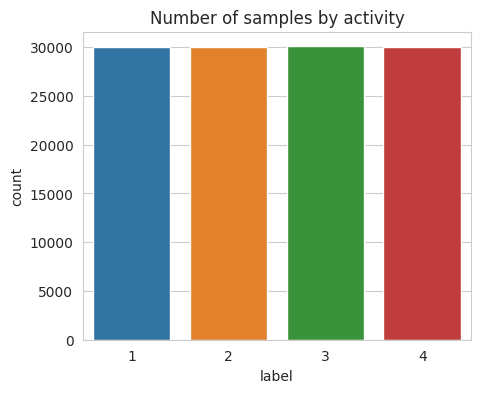

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize = (5, 4))
sns.countplot(x = 'label', data = explore_df)
plt.title('Number of samples by activity')
plt.show()

<Axes: >

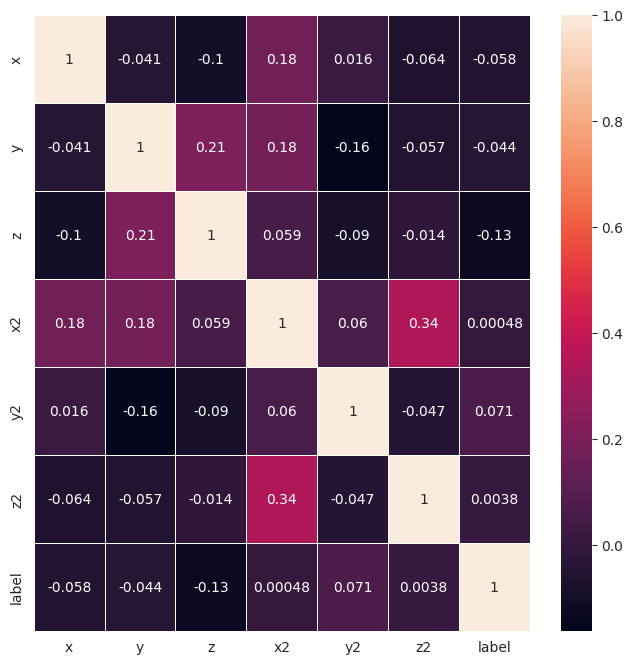

In [ ]:
#correlation matrix
corr_matrix=explore_df.corr()
corr_matrix

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=corr_matrix, annot=True, linewidths=.5, ax=ax)

## Data Segmentation

In [8]:
lstm_df = pd.read_parquet("gs://sensordatalogger-logfiles.appspot.com/har.parquet", engine='auto')
print(lstm_df.shape)

(120245, 7)


In [9]:
# windowing

n_time_steps = 50
n_features = 6
step = 25
n_classes = 4
segments = []
labels = []

for i in range(0,  lstm_df.shape[0]- n_time_steps, step):

    x_acce = lstm_df['x'].values[i: i + 50]
    y_acce = lstm_df['y'].values[i: i + 50]
    z_acce = lstm_df['z'].values[i: i + 50]
    x_gyro = lstm_df['x2'].values[i: i + 50]
    y_gyro = lstm_df['y2'].values[i: i + 50]
    z_gyro = lstm_df['z2'].values[i: i + 50]
    label_mode_result = stats.mode(lstm_df['label'][i: i + 50])
    if np.isscalar(label_mode_result[0]):
      label = label_mode_result[0]
    else:
      label = label_mode_result.mode[0]

    segments.append([x_acce, y_acce, z_acce, x_gyro, y_gyro, z_gyro])
    labels.append(label)

reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
print(reshaped_segments.shape)
print(labels.shape)

(4808, 50, 6)
(4808, 4)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3846, 50, 6)
(3846, 4)
(962, 50, 6)
(962, 4)


## Model Training and Evaluation

In [11]:
def create_lstm_model(dr=0.3, lr=0.0025):
  model = tf.keras.models.Sequential()
  model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(dr))
  model.add(Dense(y_train.shape[1], activation = 'softmax'))
  optimizer = Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [12]:
model = create_lstm_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 5124 (20.02 KB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
batch_size = 4
n_epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, callbacks=[early_stopping], batch_size = batch_size, verbose = 1)

Epoch 1/50
769/769 [==============================] - 12s 6ms/step - loss: 0.7570 - accuracy: 0.6694 - val_loss: 0.4960 - val_accuracy: 0.7922
Epoch 2/50
769/769 [==============================] - 5s 6ms/step - loss: 0.4078 - accuracy: 0.8547 - val_loss: 0.3367 - val_accuracy: 0.8792
Epoch 3/50
769/769 [==============================] - 5s 6ms/step - loss: 0.2978 - accuracy: 0.9034 - val_loss: 0.2267 - val_accuracy: 0.9299
Epoch 4/50
769/769 [==============================] - 4s 6ms/step - loss: 0.2408 - accuracy: 0.9230 - val_loss: 0.2148 - val_accuracy: 0.9351
Epoch 5/50
769/769 [==============================] - 6s 8ms/step - loss: 0.2075 - accuracy: 0.9327 - val_loss: 0.1708 - val_accuracy: 0.9481
Epoch 6/50
769/769 [==============================] - 4s 5ms/step - loss: 0.1836 - accuracy: 0.9415 - val_loss: 0.1602 - val_accuracy: 0.9468
Epoch 7/50
769/769 [==============================] - 5s 7ms/step - loss: 0.1615 - accuracy: 0.9486 - val_loss: 0.1511 - val_accuracy: 0.9519
Epoch

In [14]:
tf.saved_model.save(model, "Downloads/HAR_LSTM_model")

In [ ]:
import tensorflow as tf

model = tf.saved_model.load("Downloads/HAR_LSTM_model")
converter = tf.lite.TFLiteConverter.from_saved_model("Downloads/HAR_LSTM_model")
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('/path/to/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

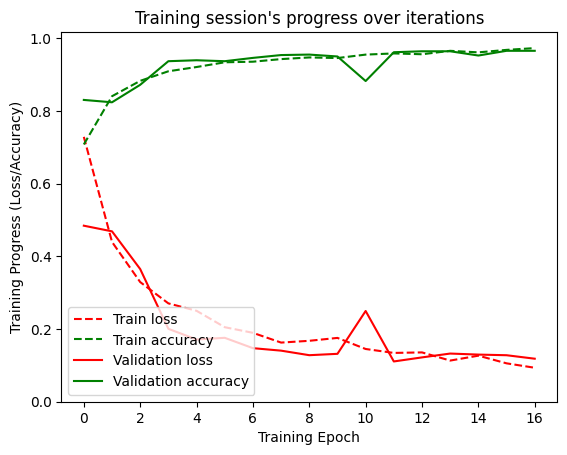

In [ ]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, batch_size = batch_size, verbose = 1)
y_pred_train = model.predict(X_train, batch_size = batch_size, verbose=1)
mse_train = mean_squared_error(y_pred_train, y_train)
rmse_train = np.sqrt(mse_train)

print("Train Accuracy: ", accuracy)
print("Train Loss: ", loss)
print ("Train RMSE: ", rmse_train)

962/962 [==============================] - 3s 2ms/step
Train Accuracy:  0.9713988304138184
Train Loss:  0.08252749592065811
Train RMSE:  0.10210643


121/121 [==============================] - 0s 3ms/step


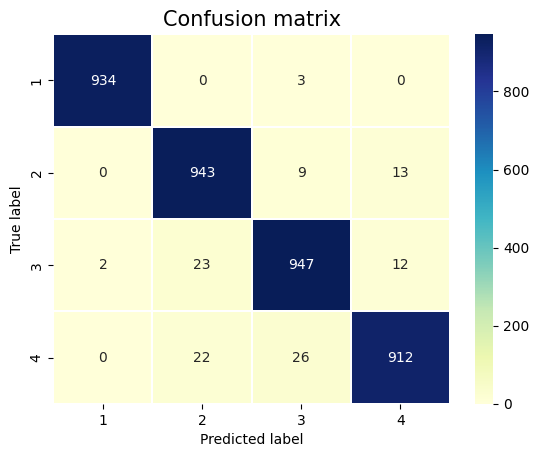

In [ ]:
predictions = model.predict(X_train)
class_labels = ['1', '2', '3', '4']
max_train = np.argmax(y_train, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_train, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Hyperparameter Tuning

In [ ]:
keras_model = KerasClassifier(build_fn=create_lstm_model, verbose=0, batch_size=4, dr=0.2, epochs=30, lr=0.001)
param_grid = {
    'batch_size': [4, 16, 32],
    'dr': [0.2, 0.3, 0.4],
    'epochs': [30, 40, 50],
    'lr': [0.001, 0.0025]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_result = grid.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping])
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_.model

print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

Best Parameters:  {'batch_size': 16, 'dr': 0.2, 'epochs': 50, 'lr': 0.0025}
Best Accuracy:  0.9648985959438378


## Model Testing

In [ ]:
tuned_model = tf.keras.models.Sequential()
tuned_model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2])))
tuned_model.add(Dropout(0.2))
tuned_model.add(Dense(y_train.shape[1], activation = 'softmax'))
optimizer = Adam(learning_rate=0.0025)
tuned_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 5124 (20.02 KB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
batch_size = 16
n_epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = tuned_model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, callbacks=[early_stopping], batch_size = batch_size, verbose = 1)

Epoch 1/50
193/193 [==============================] - 19s 23ms/step - loss: 0.7763 - accuracy: 0.6795 - val_loss: 0.5510 - val_accuracy: 0.7987
Epoch 2/50
193/193 [==============================] - 2s 13ms/step - loss: 0.4754 - accuracy: 0.8231 - val_loss: 0.4053 - val_accuracy: 0.8506
Epoch 3/50
193/193 [==============================] - 2s 10ms/step - loss: 0.3639 - accuracy: 0.8761 - val_loss: 0.3044 - val_accuracy: 0.9130
Epoch 4/50
193/193 [==============================] - 2s 11ms/step - loss: 0.2910 - accuracy: 0.9064 - val_loss: 0.2617 - val_accuracy: 0.9182
Epoch 5/50
193/193 [==============================] - 2s 11ms/step - loss: 0.2688 - accuracy: 0.9119 - val_loss: 0.1963 - val_accuracy: 0.9416
Epoch 6/50
193/193 [==============================] - 3s 14ms/step - loss: 0.2766 - accuracy: 0.9077 - val_loss: 0.3317 - val_accuracy: 0.8961
Epoch 7/50
193/193 [==============================] - 2s 12ms/step - loss: 0.2279 - accuracy: 0.9220 - val_loss: 0.1880 - val_accuracy: 0.936

In [ ]:
# use best model
loss_tuned, accuracy_tuned = tuned_model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
y_pred_tuned = tuned_model.predict(X_test)
mse_tuned = mean_squared_error(y_pred_tuned, y_test)
rmse_tuned = np.sqrt(mse_tuned)

print("Test Accuracy: ", accuracy_tuned)
print("Test Loss: ", loss_tuned)
print("Test RMSE: ", rmse_tuned)

31/31 [==============================] - 0s 3ms/step
Test Accuracy:  0.9553014636039734
Test Loss:  0.14069998264312744
Test RMSE:  0.13145277


31/31 [==============================] - 0s 3ms/step


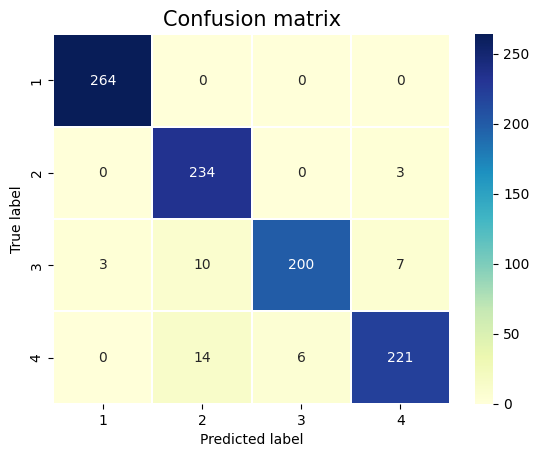

In [ ]:
# use best model
predictions = tuned_model.predict(X_test)
class_labels = ['1', '2', '3', '4']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

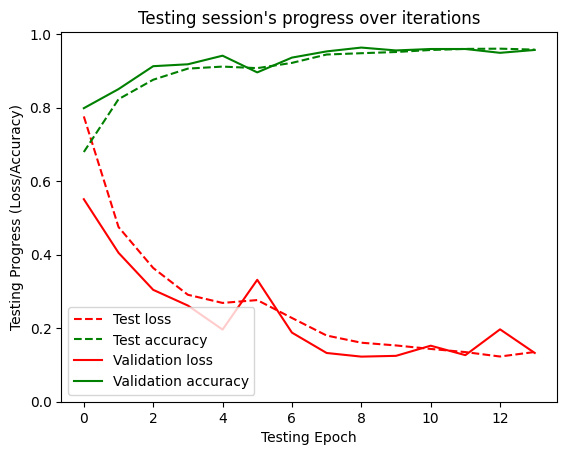

In [ ]:
plt.plot(np.array(history.history['loss']), "r--", label = "Test loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Test accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Testing session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Testing Progress (Loss/Accuracy)')
plt.xlabel('Testing Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# model testing
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_pred_test, y_test)
rmse_test = np.sqrt(mse_test)

print("Test Accuracy: ", accuracy)
print("Test Loss: ", loss)
print("Test RMSE: ", rmse_test)

31/31 [==============================] - 0s 3ms/step
Test Accuracy:  0.9563409686088562
Test Loss:  0.15146298706531525
Test RMSE:  0.13548326


31/31 [==============================] - 0s 3ms/step


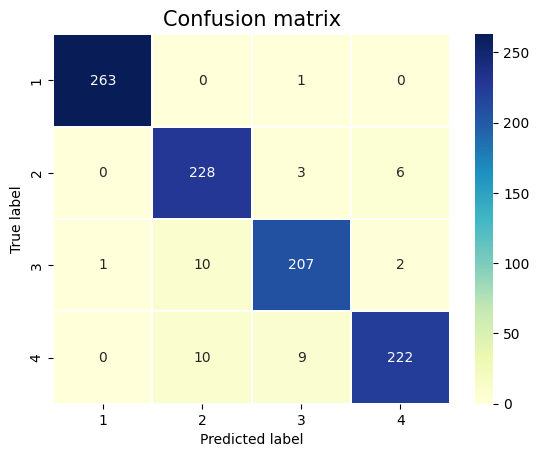

In [ ]:
predictions = model.predict(X_test)
class_labels = ['1', '2', '3', '4']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def grid(classifier):

    # define the grid search parameters
    batch_size = [32, 64, 128]
    epochs = [30, 40, 50]
    lstm_units: [32, 64, 128]
    dropout_rate: [0.2, 0.3, 0.4]
    validation_split=[0.2]

    param_grid = dict(batch_size=batch_size, epochs=epochs, dropout_rate=dropout_rate, lstm_units=lstm_units, validation_split=validation_split)

    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True, verbose=2)

    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result

In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 6
    segments = []
    labels = []

    for i in range(0, len(df) - time_steps, step):
        acce_x = df['x'].values[i:i+time_steps]
        acce_y = df['y'].values[i:i+time_steps]
        acce_z = df['z'].values[i:i+time_steps]
        gyro_x = df['x2'].values[i:i+time_steps]
        gyro_y = df['y2'].values[i:i+time_steps]
        gyro_z = df['z2'].values[i:i+time_steps]

        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([acce_x, acce_y, acce_z, gyro_x, gyro_y, gyro_z])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

TIME_PERIOD = 100
STEP_DISTANCE = 50
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)

print(x_train.shape)
print(x_train.shape[0])
print(y_train.shape)
print(x_test.shape)
print(x_test.shape[0])
print(y_test.shape)

In [ ]:
df_new = X_new.copy()
df_new['label'] = Y_new
df_new['label'] = df_new['label'].astype(int)

print(df_new.shape)

(720, 225)


In [ ]:
label_encode = LabelEncoder()
df_new['activityEncode'] = label_encode.fit_transform(df_new['label'].values.ravel())

In [ ]:
X = df_new.drop('activityEncode',axis=1)
y = df_new['activityEncode']
y = y.to_numpy()
y = y.astype('int')

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(720, 225)
(720,)
(576, 225)
(576,)
(144, 225)
(144,)


In [ ]:
# train data
df_train = pd.DataFrame(X_train)
df_train['activityEncode'] = y_train
print(df_train)
print(df_train.shape)

# test data
df_test = pd.DataFrame(X_test)
df_test['activityEncode'] = y_test
print(df_test)
print(df_test.shape)

     acce_x_mean  acce_y_mean  acce_z_mean  gyro_x_mean  gyro_y_mean  \
395      -0.6251       9.8663      -0.3829       0.1221       0.1923   
41       -0.4124       9.8022      -0.0361      -0.0006       0.0029   
108      -0.4445       9.8004      -0.1043      -0.0002      -0.0052   
644      -0.5532       9.8708      -0.5330       0.1096       0.1394   
56       -0.4390       9.8018      -0.0779       0.0020       0.0034   
..           ...          ...          ...          ...          ...   
71       -0.4395       9.7994      -0.1194       0.0037       0.0025   
106      -0.4564       9.7999      -0.1263      -0.0015       0.0023   
270      -0.7815       9.7805      -0.0795      -0.0037      -0.0003   
435      -0.5007       9.8625      -0.2058      -0.1783      -0.0456   
102      -0.4488       9.7979      -0.1946       0.0011      -0.0048   

     gyro_z_mean  acce_x_std  acce_y_std  acce_z_std  gyro_x_std  ...  \
395      -0.0218    1.648365    2.904234    2.381432    0.8671

In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 224
    segments = []
    labels = []

    for i in range(0, len(df) - time_steps, step):
        segment_data = []

        for column in df.columns:
            if column != 'activityEncode' and column != 'label':
                segment = df[column].values[i:i+time_steps]
                segment_data.append(segment)

        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append(segment_data)
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13, 80, 224)
(13,)
(2, 80, 224)
(2,)


In [ ]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

[1, 2]


In [ ]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  17920
Input Data Shape:  (13, 17920)


In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [ ]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (13, 2)


In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 17920, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((8960, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((2239, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(2))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 17920, 32)         4352      
                                                                 
 lstm_32 (LSTM)              (None, 17920, 32)         8320      
                                                                 
 reshape_22 (Reshape)        (None, 1, 17920, 32)      0         
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 8960, 64)       4160      
                                                                 
 reshape_23 (Reshape)        (None, 8960, 64)          0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 2240, 64)          0         
 g1D)                                                            
                                                     

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=50
                   )

Epoch 1/50
1/1 [==============================] - 85s 85s/step - loss: nan - accuracy: 0.4615
Epoch 2/50
1/1 [==============================] - 86s 86s/step - loss: nan - accuracy: 0.4615
Epoch 3/50
1/1 [==============================] - 98s 98s/step - loss: nan - accuracy: 0.4615
Epoch 4/50
1/1 [==============================] - 85s 85s/step - loss: nan - accuracy: 0.4615
Epoch 5/50
1/1 [==============================] - 85s 85s/step - loss: nan - accuracy: 0.4615
Epoch 6/50
1/1 [==============================] - 99s 99s/step - loss: nan - accuracy: 0.4615
Epoch 7/50
1/1 [==============================] - 81s 81s/step - loss: nan - accuracy: 0.4615
Epoch 8/50
1/1 [==============================] - 84s 84s/step - loss: nan - accuracy: 0.4615
Epoch 9/50
1/1 [==============================] - 84s 84s/step - loss: nan - accuracy: 0.4615
Epoch 10/50
1/1 [==============================] - 81s 81s/step - loss: nan - accuracy: 0.4615
Epoch 11/50
1/1 [==============================] - 81s 81s/

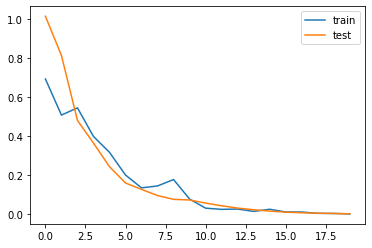

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [ ]:
x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [ ]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 6
    segments = []
    labels = []

    for i in range(0, len(df) - time_steps, step):
        acce_x = df['x'].values[i:i+time_steps]
        acce_y = df['y'].values[i:i+time_steps]
        acce_z = df['z'].values[i:i+time_steps]
        gyro_x = df['x2'].values[i:i+time_steps]
        gyro_y = df['y2'].values[i:i+time_steps]
        gyro_z = df['z2'].values[i:i+time_steps]

        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([acce_x, acce_y, acce_z, gyro_x, gyro_y, gyro_z])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

TIME_PERIOD = 100
STEP_DISTANCE = 50
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)

print(x_train.shape)
print(x_train.shape[0])
print(y_train.shape)
print(x_test.shape)
print(x_test.shape[0])
print(y_test.shape)

(575, 100, 6)
575
(575,)
(143, 100, 6)
143
(143,)


In [ ]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x', 'y', 'z', 'x2', 'y2', 'z2']],
    df_train.label,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x', 'y', 'z', 'x2', 'y2', 'z2']],
    df_test.label,
    TIME_STEPS,
    STEP
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),  # Adjust input shape
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')  # Adjust num_classes
])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.fit(X_train, y_train, batch_size=4, epochs=30, verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 32)                4992      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 2)                 66        
                                                                 
Total params: 5058 (19.76 KB)
Trainable params: 5058 (19.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),  # Adjust input shape
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')  # Adjust num_classes
])

In [ ]:
def create_lstm_model():
  model = tf.keras.models.Sequential()
  model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))
  #model.add(Dense(units = 64, activation='relu'))
  model.add(Dense(y_train.shape[1], activation = 'softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## Model Validation

In [ ]:
# Train the model with the best hyperparameters
best_lstm_model = create_lstm_model(units=best_params['units'], activation=best_params['activation'], optimizer=best_params['optimizer'])
best_lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Evaluate the model on the test data
y_pred = best_lstm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Data:", mse)